# 0. Importing Necessary Packages

In [1]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'pyraf']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.20.3
matplotlib: ver 3.5.0
pandas: ver 1.3.5
astropy: ver 3.2.3
pyraf: ver 2.1.15


In [10]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import time
import numpy as np
import glob, os
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

current_dir = os.getcwd()
dir_iraf = os.path.abspath('/data2/iraf/')    # where 'login.cl' file is located

os.chdir(dir_iraf)
from pyraf import iraf
os.chdir(current_dir)

# 1. Examining Point Sources in the Images

### 1) Displaying the Images with DS9

In [11]:
os.chdir('/data2/astronomicalobservation/')

In [12]:
dir_img = "n2041/"
imglist = [dir_img+"n2041b.fits", dir_img+"n2041v.fits"]
n_img = len(imglist)
band = ["b", "v"]
imglist

['n2041/n2041b.fits', 'n2041/n2041v.fits']

In [13]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image n2041/n2041b.fits n2041/n2041v.fits &" in the terminal...


0

### 2) Running ``imexamine`` Task

#### The ``imexamine`` task ([Reference link](https://iraf.net/irafhelp.php?val=imexamine&help=Help+Page)) is very useful for checking the information of sources in the images!

In [14]:
# Interactively checking the sources
iraf.imexamine()

#### Please check your mouse cursor blinking in the DS9 window.
#### You can check the selected sources in the images interactively by pressing the following keys.
* ``a`` key: to **select a source** and view its basic information
    * see **``MOFFAT`` to check the FWHM size of the source**)


* ``r`` key: to show **the radial light profile** of the source
* ``e`` key: to show **the contour plot** of the source
* ``s`` key: to show **the surface plot** of the source


* ``q`` key: to quit

### 3) Measuring FWHMs and Saving the Results

In [15]:
# Interactively selecting good point sources in the g-band image
# This task is to estimate the seeing FWHMs of point sources in this image.
# Plus, the selection of point sources will be used as initial PSF stars (next notebook).
logname_b = dir_img+"imexam_b.log"
os.system("rm -rfv "+logname_b)
iraf.imexamine(logfile = logname_b, keeplog = "yes")

Log file n2041/imexam_b.log open
#   COL    LINE   COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
 198.85  144.16 198.85 144.16
   8.26  15.11   9038.     28.   761.4 0.16  -36 9.12     2.76     2.89   2.75
 196.27  129.84 196.27 129.84
   8.06  14.94  10611.     27.   1047. 0.08   17 3.34     2.72     2.67   2.69
 138.43  130.76 138.43 130.76
   8.19  14.76  12441.     28.   1172. 0.23  -11 2.65     2.76     2.69   2.73
 109.95  172.10 109.95 172.10
   8.01  14.22  20485.     29.   1823. 0.08   87 6.38     2.68     2.81   2.67
  10.45   51.19   10.45 51.19
   8.47  15.19   8431.     27.   730.9 0.14    0 5.63     2.85     2.90   2.82
 209.84   39.83  209.84 39.83
   8.05  15.88   4429.     24.   395.7 0.28   15 3.65     2.69     2.78   2.68
 181.27   25.54  181.27 25.54
   8.42  15.98   4054.     24.   357.3 0.09  -33 3.77     2.82     2.80   2.81
 279.46   28.38  279.46 28.38
   8.42  15.67   5415.     26.    499. 0.50   12 5.40     2.83   

In [16]:
poi_b = np.genfromtxt(logname_b, usecols=(0,1,7,9,13), names=('X','Y','SKY','E','MOFFAT'))
med_fwhm_b = np.median(poi_b['MOFFAT'][poi_b['E'] <= 0.15])
print("Using {0:d} sources".format(np.sum(poi_b['E'] <= 0.15)))
print("Median FWHMs of point sources fitted by Moffat profile: {0:.2f} pix (g-band)".format(med_fwhm_b))

Using 8 sources
Median FWHMs of point sources fitted by Moffat profile: 2.76 pix (g-band)


* **Display the ``imexam_g.log`` in the images with the DS9 region.**

    * In DS9, ``Region`` - ``Load Regions`` - Check ``All(*)`` - Set the format (``xy``) and coordinate system (``image``).

In [17]:
# Interactively checking the sources in the i-band image
logname_v = dir_img+"imexam_.log"
os.system("rm -rfv "+logname_v)
iraf.imexamine(logfile = logname_v, keeplog = "yes")

Log file n2041/imexam_.log open
#   COL    LINE  COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
  10.73  389.76 10.73 389.76
   8.41  13.08  58526.     50.   4844. 0.09  -41 5.46     2.83     3.08   2.80
  42.95  187.69 42.95 187.69
   8.48  14.98  10192.     48.   809.6 0.06  -55 5.87     2.84     2.93   2.83
  34.67  145.36 34.67 145.36
   9.46  15.79   4842.     45.   320.4 0.58   58 5.76     3.51     2.89   3.49
 109.99  172.55 109.99 172.55
   8.35  13.17  54194.     49.   4557. 0.06  -16 8.63     2.82     2.92   2.78
 138.63  131.14 138.63 131.14
   8.71  15.10   9129.     48.   772.8 0.36   -9 6.30     2.94     2.96   2.90
 182.92  176.35 182.92 176.35
   8.40  14.12  22561.     49.   1780. 0.17   16 4.72     2.81     2.89   2.80
 199.07  144.62 199.07 144.62
   8.33  14.30  19025.     50.   1559. 0.16  -22 7.11     2.79     2.93   2.78
 196.42  130.24 196.42 130.24
   8.49  14.00  25076.     49.   2174. 0.13   -8 4.86     2.87     2.8

In [20]:
logname_v = '/data2/astronomicalobservation/n2041/imexam_v.log'

In [21]:
poi_v = np.genfromtxt(logname_v, usecols=(0,1,7,9,13), names=('X','Y','SKY','E','MOFFAT'))
med_fwhm_v = np.median(poi_v['MOFFAT'][poi_v['E'] <= 0.15])
print("Using {0:d} sources".format(np.sum(poi_v['E'] <= 0.15)))
print("Median FWHMs of point sources fitted by Moffat profile: {0:.2f} pix (v-band)".format(med_fwhm_v))

Using 9 sources
Median FWHMs of point sources fitted by Moffat profile: 2.88 pix (v-band)


In [22]:
np.savetxt(dir_img+"fwhms.txt", [med_fwhm_b, med_fwhm_v], fmt="%.3f")

In [31]:
poi_init = np.genfromtxt(logname_b, usecols=(0,1,9), names=('X','Y','E'))
xlist = []
ylist = []
for x, y, e in poi_init[poi_init['E'] <= 0.30]:
    xlist.append(x)
    ylist.append(y)


In [28]:
from astropy.table import Table

In [29]:
tbl = Table()

In [33]:
tbl['X'] = xlist
tbl['Y'] = ylist

In [35]:
tbl.write('init_point.reg', format= 'ascii')

* **Save the region file (``init_point.reg``) of _good_ point sources**.

    * Set the format (``xy``) and coordiate system (``image``).
    
    * This region file will be used for initial PSF-selected stars for PSF photometry ``PSF_photometry.ipynb`` ([Link](https://nbviewer.org/github/joungh93/TAO_2022A/blob/main/PSF_photometry.ipynb)).

# 2. Finding Stars in the Images

### 1) Sky Estimation

#### Here we use the [MMM algorithm](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground) for global sky estimation of the image.

In [36]:
img_g = fits.getdata(imglist[0])
img_i = fits.getdata(imglist[1])

In [37]:
# Sky, skysigma estimation
sky_value = []
sky_sigma = []
for img in [img_g, img_i]:
    avg, med, std = sigma_clipped_stats(img, sigma=3.0)
    sky_val = 3.0*med - 2.0*avg    # MMM algorithm for sky estimation
    sky_value.append(sky_val)
    sky_sig = std
    sky_sigma.append(sky_sig)
    print(sky_val, sky_sig)

25.088978152814704 9.478004928292027
44.447552447552454 9.511867470845385


In [39]:
np.savetxt(dir_img+"sky.txt", [sky_value, sky_sigma], delimiter="  ", fmt="%.3e")

### 2) Running ``daofind`` Task

* **Reference link: [daofind](https://iraf.net/irafhelp.php?val=daofind)**

In [40]:
iraf.noao()
iraf.digiphot()
iraf.daophot()

daophot/:
 addstar        daotest         nstar           pexamine        psf
 allstar        datapars@       pcalc           pfmerge         psort
 centerpars@    findpars@       pconcat         phot            pstselect
 daoedit        fitskypars@     pconvert        photpars@       seepsf
 daofind        group           pdump           prenumber       setimpars
 daopars@       grpselect       peak            pselect         substar


In [47]:
# DAOFIND task
band = ["b", "v"]
fwhms = [med_fwhm_b, med_fwhm_v]

start_time = time.time()
for i in np.arange(n_img):
    imgname = imglist[i].split(".fits")[0]
    coofile = imgname+".coo"
    os.system("rm -rfv "+coofile)
    
    kwargs = {"fwhmpsf":fwhms[i], "sigma":sky_sigma[i], "threshold":3, "verify":False}
    iraf.daofind(image=imglist[i], output=coofile, **kwargs)
end_time = time.time()
print("\n--- DAOFIND tasks take {0:.4f} sec ---".format(end_time-start_time))


Image: n2041/n2041b.fits  fwhmpsf: 2.765  ratio: 1.  theta: 0.  nsigma: 1.5

  204.29     6.15   -1.970   0.565  -0.144  -0.222     1
  267.30     5.42   -0.393   0.551   0.188  -0.191     2
  255.47     6.75   -0.536   0.518  -0.186  -0.510     3
  111.73     7.92   -0.501   0.732   0.190  -0.232     4
   29.29     8.35   -0.433   0.429   0.402  -0.263     5
   39.98     9.27   -0.034   0.608   0.267  -0.120     6
  280.82     8.89   -0.674   0.514   0.009  -0.295     7
  216.52    10.10   -1.791   0.516  -0.130  -0.212     8
  211.55    11.06   -0.180   0.935   0.783  -0.533     9
  271.84    12.18   -0.730   0.471  -0.165  -0.251    10
  202.50    12.56   -0.277   0.428   0.227   0.286    11
  120.82    15.07   -0.340   0.589  -0.761  -0.573    12
   41.74    15.89   -0.710   0.623   0.232  -0.034    13
  237.33    15.84   -1.427   0.518  -0.354  -0.253    14
   22.32    16.61   -0.480   0.584  -0.458  -0.344    15
   16.37    19.42   -1.494   0.507   0.255  -0.115    16
    3.20  

  291.66   161.37   -1.723   0.489  -0.397  -0.198   144
   95.97   163.23   -0.258   0.604   0.059  -0.519   145
  255.15   162.80   -0.440   0.406  -0.234  -0.213   146
  152.59   163.29   -0.242   0.445  -0.145  -0.152   147
  162.16   168.16   -0.055   0.631  -0.362   0.081   148
  149.60   169.68   -1.160   0.595  -0.694  -0.443   149
  109.89   172.15   -4.243   0.543  -0.239  -0.140   150
  233.97   172.81   -4.121   0.552  -0.167  -0.189   151
  194.29   174.48   -3.505   0.513  -0.282  -0.094   152
   44.20   176.04   -0.658   0.582   0.576  -0.572   153
   48.67   176.04   -2.138   0.539  -0.404  -0.322   154
  182.75   175.95   -3.420   0.558  -0.258  -0.257   155
   70.67   179.56   -0.059   0.560   0.025   0.029   156
  171.96   179.20   -0.357   0.583   0.004  -0.600   157
  244.81   178.49   -0.778   0.505   0.103  -0.079   158
  109.88   180.69   -0.872   0.511  -0.126  -0.326   159
  187.02   181.72   -0.933   0.571   0.070  -0.041   160
  260.53   182.63   -0.729   0.

  147.16   250.98   -3.069   0.565  -0.223  -0.191   288
   36.85   252.29   -4.993   0.527  -0.275  -0.111   289
   69.01   252.71   -0.113   0.645  -0.611  -0.517   290
   73.65   253.27   -1.206   0.552   0.159  -0.314   291
   83.51   253.01   -0.641   0.584  -0.272  -0.097   292
  151.95   253.49   -3.061   0.539  -0.434  -0.181   293
  181.98   253.28   -1.479   0.541  -0.065  -0.441   294
  169.49   254.65   -1.127   0.472  -0.156  -0.650   295
  177.24   253.88   -1.064   0.584   0.198  -0.085   296
  126.83   255.83   -1.813   0.560  -0.014  -0.349   297
  138.60   255.37   -1.224   0.546  -0.419  -0.165   298
  201.78   254.60   -2.273   0.548  -0.031  -0.057   299
  286.03   255.35   -0.921   0.585  -0.257  -0.200   300
   57.20   255.44   -3.411   0.527  -0.154   0.014   301
  158.49   256.59   -1.582   0.521  -0.371  -0.179   302
    6.75   256.73   -0.212   0.441   0.453   0.732   303
   44.25   256.74   -2.206   0.533  -0.172  -0.123   304
  105.08   257.02   -2.020   0.

  172.21   293.99   -2.167   0.514  -0.135  -0.294   432
  221.69   294.27   -2.077   0.815  -0.780  -0.168   433
  138.29   294.91   -4.030   0.478   0.230   0.089   434
  197.54   295.34   -1.032   0.617  -0.447  -0.540   435
   70.19   296.00   -2.269   0.546  -0.362  -0.218   436
  113.03   296.66   -2.799   0.457   0.120  -0.732   437
  154.80   296.96   -1.905   0.464  -0.284   0.821   438
   94.70   295.73   -1.531   0.666   0.577   0.150   439
  135.08   296.40   -2.828   0.624   0.091  -0.745   440
  144.43   297.12   -4.552   0.552  -0.764  -0.268   441
  203.30   297.12   -1.782   0.544  -0.277  -0.208   442
  109.11   298.08   -2.229   0.542  -0.451  -0.712   443
  138.19   296.50   -3.047   0.590   0.229   0.208   444
  177.68   298.22   -1.432   0.501  -0.346  -0.128   445
  191.00   298.32   -0.337   0.436  -0.013  -0.309   446
  209.23   297.57   -2.785   0.520  -0.441  -0.198   447
  249.00   298.56   -0.652   0.567  -0.351   0.134   448
  279.42   298.28   -1.981   0.

   13.08   341.92   -0.062   0.712  -0.015   0.008   576
  102.26   341.99   -1.394   0.574   0.029   0.208   577
  176.73   342.50   -0.029   0.564  -0.511  -0.826   578
   82.62   343.36   -0.219   0.464   0.143   0.402   579
  253.37   342.95   -0.588   0.546  -0.860  -0.365   580
  292.63   343.07   -4.559   0.545  -0.445  -0.283   581
  160.14   344.07   -1.325   0.403  -0.238   0.538   582
    7.03   345.11   -0.284   0.586  -0.329  -0.264   583
   54.19   344.95   -0.006   0.608   0.026   0.125   584
   99.49   344.59   -0.118   0.698  -0.939   0.062   585
   35.45   345.40   -0.896   0.562  -0.163  -0.005   586
   89.33   345.44   -0.666   0.604  -0.263   0.219   587
  135.18   346.17   -2.313   0.501  -0.875  -0.453   588
  219.72   346.53   -0.122   0.579   0.714   0.038   589
  304.30   346.37   -0.238   0.561  -0.002  -0.175   590
   73.67   346.91   -2.243   0.558  -0.189  -0.325   591
  120.13   348.26   -3.141   0.560  -0.176  -0.193   592
  147.25   347.62   -1.512   0.

   26.19   419.19   -0.068   0.692  -0.282  -0.231   720
  157.52   419.25   -2.049   0.528  -0.241  -0.371   721
  292.35   419.69   -2.534   0.547  -0.481  -0.229   722
  244.94   421.10   -0.241   0.456   0.016  -0.753   723
  239.18   423.87   -1.490   0.629  -0.354  -0.353   724
   98.68   424.78   -0.648   0.459  -0.379  -0.108   725
  209.89   426.21   -0.345   0.452  -0.709  -0.337   726
  306.47   426.77   -4.559   0.543  -0.470  -0.277   727
   68.60   430.68   -1.290   0.538  -0.468  -0.366   728
  250.85   431.28   -0.320   0.542  -0.293  -0.264   729
   91.15   431.62   -0.428   0.569  -0.553  -0.385   730
   85.06   432.50   -1.017   0.567   0.036  -0.054   731
   97.37   434.65   -0.369   0.654  -0.649  -0.266   732
  194.61   434.44   -0.646   0.476  -0.008  -0.344   733
  122.04   435.42   -1.669   0.530  -0.363   0.011   734
   53.23   438.96   -1.067   0.504   0.050  -0.149   735
  214.05   439.60   -0.370   0.533  -0.254  -0.185   736
   95.00   441.82   -3.119   0.

  207.69    92.77   -1.450   0.490  -0.069  -0.234    70
  161.18    94.45   -0.130   0.702   0.227   0.022    71
  223.11    98.58   -2.530   0.493  -0.398  -0.124    72
   96.20    99.79   -0.601   0.524  -0.310  -0.162    73
   50.40   101.15   -0.237   0.519  -0.373  -0.724    74
  136.94   103.80   -0.683   0.479   0.018  -0.099    75
  201.82   104.10   -1.210   0.488  -0.339  -0.154    76
  252.47   107.06   -2.402   0.482  -0.519  -0.331    77
  296.90   108.93   -0.653   0.473  -0.721  -0.016    78
  195.00   110.28   -1.650   0.454  -0.433  -0.214    79
  180.48   110.98   -0.507   0.522  -0.011  -0.177    80
  291.56   112.66   -1.339   0.523  -0.546  -0.313    81
   10.75   112.75   -0.193   0.580  -0.486  -0.295    82
  300.97   113.07   -3.357   0.528  -0.474  -0.210    83
  136.16   114.60   -0.899   0.388  -0.262  -0.084    84
  172.18   117.39   -0.554   0.448  -0.050   0.030    85
  218.92   119.37   -0.098   0.613   0.855   0.674    86
   17.19   119.71   -0.617   0.

   53.80   228.51   -0.228   0.407  -0.115  -0.117   214
   64.40   228.90   -2.270   0.524  -0.303  -0.241   215
  117.26   231.41   -0.352   0.496  -0.349  -0.088   216
   28.28   232.75   -1.242   0.444  -0.320  -0.236   217
   82.91   233.04   -0.519   0.527  -0.255  -0.476   218
  212.38   233.57   -0.939   0.637  -0.521   0.095   219
  122.78   234.03   -0.561   0.479   0.153  -0.631   220
  131.57   234.41   -0.275   0.689  -0.513  -0.403   221
  234.22   234.56   -2.001   0.515  -0.207  -0.095   222
   44.95   235.04   -0.809   0.442  -0.358  -0.286   223
  124.16   234.63   -0.498   0.507   0.028  -0.912   224
  157.24   234.66   -2.259   0.526   0.612   0.351   225
  177.04   235.14   -0.654   0.564  -0.332  -0.974   226
  180.42   235.58   -1.552   0.637  -0.120  -0.205   227
  249.64   234.93   -0.676   0.449  -0.321  -0.290   228
  308.06   235.64   -1.951   0.487  -0.251   0.023   229
   73.58   235.34   -0.762   0.515  -0.287   0.034   230
    1.51   236.76   -1.521   0.

  172.48   287.51   -0.335   0.678  -0.358   0.461   358
  197.65   289.15   -0.187   0.743  -0.449  -0.385   359
  209.32   288.72   -1.010   0.528  -0.630  -0.279   360
  275.47   288.92   -0.970   0.501  -0.590  -0.482   361
  137.81   290.06   -5.000   0.528  -0.504  -0.368   362
  147.38   291.04   -3.141   0.516   0.615   0.219   363
  189.98   289.75   -0.316   0.365  -0.399  -0.157   364
  125.77   290.91   -3.916   0.551  -0.394  -0.456   365
  128.85   290.72   -3.296   0.594   0.692  -0.723   366
   67.85   291.42   -1.070   0.405  -0.395  -0.158   367
  258.83   291.84   -2.302   0.516  -0.360  -0.203   368
  267.98   292.27   -2.434   0.327   0.751   0.307   369
   42.37   292.86   -0.153   0.467  -0.305  -0.084   370
  133.26   292.95   -2.901   0.569   0.598   0.336   371
  185.11   293.51   -1.747   0.577  -0.662  -0.513   372
  243.45   292.73   -0.146   0.542  -0.755  -0.511   373
   94.19   294.33   -2.653   0.544  -0.358  -0.176   374
  107.29   294.64   -1.927   0.

  134.34   334.81   -2.956   0.539  -0.250   0.099   502
   29.45   336.23   -1.945   0.483  -0.142  -0.149   503
  205.98   335.77   -1.464   0.510  -0.189  -0.672   504
  232.83   335.99   -1.307   0.458  -0.350  -0.231   505
  222.02   337.63   -0.865   0.644  -0.567  -0.039   506
  163.90   339.17   -0.476   0.643  -0.651   0.072   507
  119.12   340.37   -3.441   0.511  -0.660  -0.382   508
  141.89   340.06   -1.228   0.540  -0.446  -0.117   509
  200.90   339.99   -1.285   0.657  -0.547  -0.138   510
  130.96   340.70   -0.888   0.664   0.666  -0.139   511
  151.51   341.19   -0.780   0.665  -0.121  -0.664   512
  168.46   340.77   -2.716   0.525  -0.454  -0.217   513
  114.29   341.32   -2.941   0.518  -0.624  -0.343   514
  272.75   341.65   -0.077   0.315   0.004  -0.033   515
  102.39   342.33   -0.848   0.441  -0.485   0.129   516
  253.58   343.36   -0.435   0.473  -0.309   0.273   517
  293.08   343.60   -4.122   0.503  -0.541  -0.128   518
  145.31   345.98   -0.315   0.

  157.69   419.83   -1.629   0.524  -0.488  -0.228   646
  292.85   420.36   -2.253   0.551  -0.595  -0.157   647
  244.95   421.36   -0.475   0.504  -0.695  -0.307   648
  239.57   424.60   -0.967   0.513  -0.048  -0.175   649
   98.58   425.59   -0.622   0.650   0.230   0.222   650
  210.57   427.61   -0.096   0.601  -0.283   0.307   651
  306.91   427.43   -4.986   0.527  -0.556  -0.126   652
   68.68   431.36   -1.161   0.561  -0.527  -0.125   653
  251.09   432.25   -0.214   0.443  -0.369  -0.367   654
   85.18   433.17   -0.717   0.656   0.191   0.126   655
   91.37   432.45   -0.267   0.426  -0.185  -0.341   656
   97.81   435.02   -0.381   0.540  -0.242  -0.186   657
  194.84   434.94   -0.509   0.620  -0.455  -0.218   658
  122.16   436.00   -1.384   0.595  -0.594  -0.087   659
   80.82   437.93   -0.771   0.513  -0.558  -0.081   660
   53.39   439.55   -1.203   0.502  -0.040  -0.146   661
  214.32   440.15   -0.901   0.518  -0.336  -0.298   662
   95.14   442.51   -3.453   0.

# 3. Aperture Photometry

### 1) Running ``phot`` Task and Saving the Results

* **Reference link: [phot](https://iraf.net/irafhelp.php?val=daophot.phot&help=Help+Page), [txdump](https://iraf.net/irafhelp.php?val=ptools.txdump&help=Help+Page)**

In [48]:
n_img

2

In [49]:
fwhms

[2.7649999999999997, 2.88]

In [50]:
sky_sigma

[9.478004928292027, 9.511867470845385]

In [51]:
coofile

'n2041/n2041v.coo'

In [53]:
coofile = dir_img + 'n2041b.coo'

In [55]:
# PHOT task
start_time = time.time()
for i in np.arange(n_img):
    imgname = imglist[i].split(".fits")[0]
    coofile = dir_img + 'n2041b.coo'
    # Here we fix the coordinate file,
    # because more stars are found in the g-band image and g- and i-band images are aligned very well.
    # But it depends on the alignment and depth of each image!
    # So please be careful to fix the coordinate file.
    magfile = imgname+".mag"
    datfile = imgname+".dat"
    os.system("rm -rfv "+magfile)
    os.system("rm -rfv "+datfile)
    
    kwargs = {"fwhmpsf":fwhms[i], "sigma":sky_sigma[i],
              "datamax":16300.0, "readnoise":15.0, "epadu":2.0, "itime":1.0,
              "cbox":1.5*fwhms[i], "annulus":4*fwhms[i], "dannulus":2*fwhms[i],
              "skyvalue":sky_value[i], "apertures":1.0*fwhms[i], "zmag":27, "verify":False}
    iraf.phot(image=imglist[i], coords=coofile, output=magfile, **kwargs)
    iraf.txdump(magfile, "XINIT,YINIT,MAG,MERR,MSKY,STDEV,NSKY,SUM,AREA,FLUX","yes", Stdout=datfile)
end_time = time.time()
print("\n--- PHOT tasks take {0:.4f} sec ---".format(end_time-start_time))

n2041b.fits    204.29     6.15  24.56458   18.663  ok
n2041b.fits    267.30     5.42  23.24242   19.909  ok
n2041b.fits    255.47     6.75  24.34815   20.115  ok
n2041b.fits    111.73     7.92  24.57939   20.121  ok
n2041b.fits     29.30     8.35  23.98214   19.857  ok
n2041b.fits     39.99     9.27  23.97083   20.899  ok
n2041b.fits    280.82     8.89  23.42844   20.010  ok
n2041b.fits    216.52    10.10  22.45503   18.869  ok
n2041b.fits    211.55    11.06  24.35951   21.123  ok
n2041b.fits    271.84    12.18  23.09946   20.047  ok
n2041b.fits    202.50    12.56   21.9677   20.089  ok
n2041b.fits    120.82    15.07  24.69154   20.583  ok
n2041b.fits     41.74    15.89  23.84048   20.057  ok
n2041b.fits    237.33    15.84  22.73449   19.386  ok
n2041b.fits     22.32    16.61   24.6492   20.157  ok
n2041b.fits     16.37    19.42  25.59198   19.029  ok
n2041b.fits      3.20    20.30  26.04767    INDEF  err
n2041b.fits     65.47    19.42  24.81264   19.933  ok
n2041b.fits    219.93    21

n2041b.fits     44.20   176.04  24.86058   19.329  ok
n2041b.fits     48.67   176.04  26.30161   18.479  ok
n2041b.fits    182.75   175.95  25.57531   17.242  ok
n2041b.fits     70.67   179.56  25.32151   20.653  ok
n2041b.fits    171.96   179.20  28.00944   20.326  ok
n2041b.fits    244.81   178.49  24.90942   19.769  ok
n2041b.fits    109.88   180.69  28.78913   19.451  ok
n2041b.fits    187.02   181.72  26.49645   19.416  ok
n2041b.fits    260.53   182.63  21.66964   19.805  ok
n2041b.fits     92.59   182.55  26.93469   18.997  ok
n2041b.fits    124.98   184.35  26.94561   19.473  ok
n2041b.fits    215.24   183.48  24.06742   19.737  ok
n2041b.fits    298.42   184.06  23.49137   19.513  ok
n2041b.fits      2.80   184.45  25.43545    INDEF  err
n2041b.fits    189.58   184.74  25.62146   19.401  ok
n2041b.fits    221.10   184.19  24.68688   19.867  ok
n2041b.fits     20.66   185.91  25.41772   19.079  ok
n2041b.fits     19.53   186.28  25.68101   19.064  ok
n2041b.fits     43.02   187

n2041b.fits    105.08   257.02  78.48279   18.366  ok
n2041b.fits    123.27   256.85  79.61375   17.240  ok
n2041b.fits    129.68   257.01  62.73572   18.581  ok
n2041b.fits    304.40   257.00  25.81538   20.634  ok
n2041b.fits     97.92   257.43  78.20591   19.222  ok
n2041b.fits    297.99   257.78  25.02288   18.813  ok
n2041b.fits    147.13   258.89  71.33936   17.132  ok
n2041b.fits    150.85   258.93  80.05924   17.702  ok
n2041b.fits    181.04   259.31  55.43617   19.777  ok
n2041b.fits     50.62   260.30  30.22133   17.828  ok
n2041b.fits    241.24   260.07       28.   19.025  ok
n2041b.fits     39.93   261.13  31.30866   17.758  ok
n2041b.fits    136.56   261.63  227.7677    INDEF  ok
n2041b.fits    176.80   260.64  66.12407   19.109  ok
n2041b.fits     78.43   262.13  34.13212   18.280  ok
n2041b.fits     87.81   263.04  63.99043   20.416  ok
n2041b.fits    144.40   260.08  105.5465   17.833  ok
n2041b.fits    296.88   261.31  23.51974   19.672  ok
n2041b.fits     48.25   261.

n2041b.fits     63.11   300.79  30.79816   19.660  ok
n2041b.fits    181.97   301.30  64.68243   18.346  ok
n2041b.fits    167.83   303.02  158.6785   17.408  ok
n2041b.fits    199.14   301.67  37.53897   17.659  ok
n2041b.fits    248.09   301.58  29.32455   19.310  ok
n2041b.fits    129.44   303.96  744.0396   15.030  ok
n2041b.fits     96.50   304.83    85.914   18.511  ok
n2041b.fits    128.35   304.50   758.671   15.003  ok
n2041b.fits    156.84   303.85  220.4023   14.745  ok
n2041b.fits    105.50   305.26  128.5647   17.779  ok
n2041b.fits    139.50   305.09  812.3611   15.054  ok
n2041b.fits    176.98   305.91  88.10472   17.940  ok
n2041b.fits    280.46   305.44  27.63189   19.070  ok
n2041b.fits    116.78   306.22  299.0143   18.819  ok
n2041b.fits    147.92   305.76  427.7037   15.000  ok
n2041b.fits    188.07   305.99  64.32272   17.979  ok
n2041b.fits     94.00   306.15  64.10677   18.154  ok
n2041b.fits    122.52   305.47   367.836   16.753  ok
n2041b.fits    179.74   307.

n2041b.fits    285.35   353.36  25.01069   20.295  ok
n2041b.fits    109.96   353.39  36.43911   19.406  ok
n2041b.fits     87.85   355.59   34.2909   19.703  ok
n2041b.fits    209.25   355.09  30.97535   20.037  ok
n2041b.fits    219.94   355.46  26.61757   19.861  ok
n2041b.fits    115.38   355.87  40.07964   19.782  ok
n2041b.fits    149.14   355.47  37.63058   19.674  ok
n2041b.fits    176.29   355.57  31.73555   19.997  ok
n2041b.fits    199.51   355.61  33.04692   19.650  ok
n2041b.fits     36.72   357.83  30.55027   18.133  ok
n2041b.fits    130.55   357.65  39.26886   19.673  ok
n2041b.fits    171.84   356.99  30.35528   19.729  ok
n2041b.fits    237.52   356.77  27.37881   19.453  ok
n2041b.fits     80.47   358.25  34.30192   18.292  ok
n2041b.fits     38.97   358.48  28.40811   18.083  ok
n2041b.fits     54.63   358.77  31.55434   20.880  ok
n2041b.fits     85.81   358.58  35.74242   18.810  ok
n2041b.fits    143.46   360.88  34.33131   18.799  ok
n2041b.fits    167.76   359.

n2041b.fits    119.45   467.81  30.77938   18.516  ok
n2041b.fits    110.76   470.68  29.87469   19.797  ok
n2041b.fits    202.22   472.31  24.29167   20.303  ok
n2041b.fits    259.00   473.70  23.49675   20.273  ok
n2041b.fits    129.14   474.99  27.77352   18.463  ok
n2041b.fits    164.41   474.79  26.39588   20.382  ok
n2041b.fits    193.25   475.35  25.64249   19.953  ok
n2041b.fits    248.69   474.52  25.44621   20.830  ok
n2041b.fits    213.39   476.60  25.22757   20.381  ok
n2041b.fits    220.78   476.32  24.21121   18.950  ok
n2041b.fits    122.60   476.81  30.82837   21.168  ok
n2041b.fits    134.94   478.95  26.32977   19.861  ok
n2041b.fits    150.51   478.76  25.84977   20.308  ok
n2041b.fits    280.19   478.74  22.87826   19.516  ok
n2041b.fits      1.47   480.05  26.42534    INDEF  err
n2041b.fits    217.02   479.25  24.77271   19.733  ok
n2041b.fits    182.82   480.70  25.41101   18.800  ok
n2041b.fits     50.90   483.13   25.8475   19.744  ok
n2041b.fits    164.03   483

n2041v.fits    218.51   139.24  46.98093   19.953  ok
n2041v.fits    173.81   139.67  45.21933   20.297  ok
n2041v.fits    166.04   140.55   44.1277   20.640  ok
n2041v.fits    245.45   141.99  44.37978   18.874  ok
n2041v.fits    198.89   144.19  46.62848   16.602  ok
n2041v.fits     34.59   145.04  45.32383   18.348  ok
n2041v.fits     68.17   145.88  46.63589   20.424  ok
n2041v.fits    188.56   145.59  47.48848   19.602  ok
n2041v.fits    303.10   146.54  44.35555   18.954  ok
n2041v.fits    211.19   146.94   45.1662   19.908  ok
n2041v.fits    277.53   150.91  43.55359   19.683  ok
n2041v.fits     60.35   154.58  46.53455   20.209  ok
n2041v.fits    226.01   153.73  45.78728   20.995  ok
n2041v.fits    125.39   155.50  46.99105   18.694  ok
n2041v.fits    120.52   157.93  46.61609   20.272  ok
n2041v.fits    201.01   157.69  46.77179   19.671  ok
n2041v.fits    249.08   158.28  45.24999   19.940  ok
n2041v.fits     63.99   159.29  46.77559   19.720  ok
n2041v.fits    162.27   159.

n2041v.fits    119.11   245.07  64.84418   19.396  ok
n2041v.fits    243.80   245.24  48.89536   19.542  ok
n2041v.fits     34.99   245.47  50.59182   19.249  ok
n2041v.fits    206.18   245.89  50.34558   18.115  ok
n2041v.fits    104.00   247.08  64.75603   15.209  ok
n2041v.fits    170.22   247.83  81.93107   23.150  ok
n2041v.fits    127.19   248.00  69.29545   18.224  ok
n2041v.fits      4.76   248.63  48.75516   18.442  ok
n2041v.fits    158.24   249.10   76.6959   19.586  ok
n2041v.fits    163.08   248.91  66.92611   18.584  ok
n2041v.fits    174.82   249.05  78.13615   20.298  ok
n2041v.fits    193.12   248.82  52.76585   16.835  ok
n2041v.fits    120.76   250.40  82.59103   19.426  ok
n2041v.fits     91.38   250.65  61.59599   15.232  ok
n2041v.fits    134.85   251.12  71.87493   18.938  ok
n2041v.fits    147.16   250.98  78.06071   17.371  ok
n2041v.fits     36.85   252.29  50.90187   15.678  ok
n2041v.fits     69.01   252.71  51.55182   20.138  ok
n2041v.fits     73.65   253.

n2041v.fits     75.00   293.05   51.1455   19.713  ok
n2041v.fits    184.90   293.05   94.7048   18.645  ok
n2041v.fits     17.79   294.79  47.25081   19.556  ok
n2041v.fits     94.05   293.83  85.45287   17.589  ok
n2041v.fits    107.36   294.39  157.3817   18.437  ok
n2041v.fits    152.03   293.32  370.8638   15.665  ok
n2041v.fits    163.81   293.41  125.0255   17.972  ok
n2041v.fits    172.21   293.99  143.8351   19.815  ok
n2041v.fits    221.68   294.27  51.17857   18.609  ok
n2041v.fits    138.29   294.91   960.861   15.625  ok
n2041v.fits    197.54   295.34   57.7698   19.443  ok
n2041v.fits     70.19   296.00  51.17995   18.681  ok
n2041v.fits    113.03   296.66    127.04   16.784  ok
n2041v.fits    154.80   296.95  319.7243   16.903  ok
n2041v.fits     94.70   295.73  74.47887   17.524  ok
n2041v.fits    135.08   296.39  771.9178   16.044  ok
n2041v.fits    144.43   297.12   860.289   15.320  ok
n2041v.fits    203.30   297.12  55.23888   18.765  ok
n2041v.fits    109.11   298.

n2041v.fits    102.26   341.99  61.32372   19.213  ok
n2041v.fits    176.73   342.50  61.80724   21.085  ok
n2041v.fits     82.62   343.36  52.86127   20.795  ok
n2041v.fits    253.37   342.95  45.46162   20.064  ok
n2041v.fits    292.63   343.07  47.32114   16.540  ok
n2041v.fits    160.14   344.07  65.93174   19.361  ok
n2041v.fits      7.03   345.11  48.45485   20.507  ok
n2041v.fits     54.19   344.95  47.87698   21.091  ok
n2041v.fits     99.49   344.59  59.36025   19.813  ok
n2041v.fits     35.45   345.40  50.73016   20.172  ok
n2041v.fits     89.33   345.44  63.64166   19.319  ok
n2041v.fits    135.18   346.17  92.00351   18.725  ok
n2041v.fits    219.72   346.53  50.40767   20.526  ok
n2041v.fits    304.30   346.37  49.89407   21.107  ok
n2041v.fits     73.67   346.91  50.10506   18.570  ok
n2041v.fits    120.13   348.26  62.02904   17.725  ok
n2041v.fits    147.25   347.62  69.48558   18.795  ok
n2041v.fits    164.35   347.67  62.43015   19.477  ok
n2041v.fits    203.88   348.

n2041v.fits    250.85   431.27  48.04605   20.454  ok
n2041v.fits     91.15   431.62   48.4049   20.569  ok
n2041v.fits     85.06   432.50  47.13601   19.786  ok
n2041v.fits     97.37   434.65  48.42094   20.112  ok
n2041v.fits    194.60   434.44  48.47826   20.434  ok
n2041v.fits    122.04   435.42  49.21704   19.292  ok
n2041v.fits     53.23   438.96  48.59759   19.504  ok
n2041v.fits    214.05   439.60  47.90967   19.817  ok
n2041v.fits     95.00   441.82   48.7094   17.201  ok
n2041v.fits    234.11   441.83  47.59064   18.520  ok
n2041v.fits    272.07   442.03  45.59587   19.545  ok
n2041v.fits    151.32   443.94  47.60355   20.640  ok
n2041v.fits    290.80   445.94  45.78753   18.871  ok
n2041v.fits    300.00   446.05  48.41966   22.551  ok
n2041v.fits    151.57   451.35  47.86407   20.683  ok
n2041v.fits      7.18   451.67  45.10675   20.296  ok
n2041v.fits     18.96   452.06   45.5098   20.338  ok
n2041v.fits    125.09   451.57   49.7949   17.421  ok
n2041v.fits    185.66   451.

# 4. Drawing the Color-magnitude Diagram

In [56]:
os.getcwd()

'/data2/astronomicalobservation'

In [58]:
ap_g = pd.read_csv("n2041/n2041b.dat", sep='  ', header=None, engine='python', na_values='INDEF',
                   names=('x','y','mag','merr','msky','stdev','nsky','sum','area','flux'))
ap_g.head(10)

,x,y,mag,merr,msky,stdev,nsky,sum,area,flux
0,204.289,6.154,18.663,0.023,24.56458,6.303562,271,2758.4570,24.25645,2162.6070
1,267.298,5.423,19.909,0.057,23.24242,6.047201,264,1252.8410,24.39609,685.8165
2,255.474,6.753,20.115,0.073,24.34815,6.704029,297,1160.1430,24.34050,567.4975
3,111.733,7.916,20.121,0.078,24.57939,7.194102,296,1160.8830,24.26458,564.4742
4,29.295,8.349,19.857,0.053,23.98214,5.799807,280,1303.0230,24.31634,719.8647
5,39.985,9.273,20.899,0.137,23.97083,6.402023,320,855.9671,24.20377,275.7826
6,280.824,8.886,20.010,0.063,23.42844,6.148729,321,1195.5290,24.34463,625.1722
7,216.517,10.103,18.869,0.028,22.45503,6.911437,310,2327.4490,24.03454,1787.7530
8,211.546,11.060,21.123,0.151,24.35951,5.767833,347,809.5633,24.02853,224.2402
9,271.844,12.175,20.047,0.063,23.09946,6.022713,371,1165.5410,24.29233,604.4009


In [59]:
ap_i = pd.read_csv("n2041/n2041v.dat", sep='  ', header=None, engine='python', na_values='INDEF',
                   names=('x','y','mag','merr','msky','stdev','nsky','sum','area','flux'))
ap_i.head(10)

,x,y,mag,merr,msky,stdev,nsky,sum,area,flux
0,204.289,6.154,18.930,0.031,44.86515,7.130768,301,2869.207,26.26079,1691.0130
1,267.298,5.423,19.396,0.042,45.12186,6.526517,299,2289.736,26.36478,1100.1080
2,255.474,6.753,19.506,0.047,43.80526,6.972803,309,2148.158,26.33634,994.4883
3,111.733,7.916,19.625,0.051,46.11039,6.700955,308,2100.352,26.22525,891.0961
4,29.295,8.349,20.185,0.084,45.62064,7.077467,315,1736.481,26.39541,532.3053
5,39.985,9.273,21.038,0.167,45.46325,6.698419,353,1436.064,26.25124,242.5974
6,280.824,8.886,20.231,0.080,44.37442,6.348248,337,1677.491,26.30638,510.1607
7,216.517,10.103,19.033,0.032,44.12273,6.794457,352,2698.165,26.31447,1537.0990
8,211.546,11.060,21.230,0.191,43.38112,6.500038,390,1341.922,26.24691,203.3020
9,271.844,12.175,20.325,0.086,45.22091,6.392634,400,1654.688,26.24424,467.8993


<IPython.core.display.Javascript object>


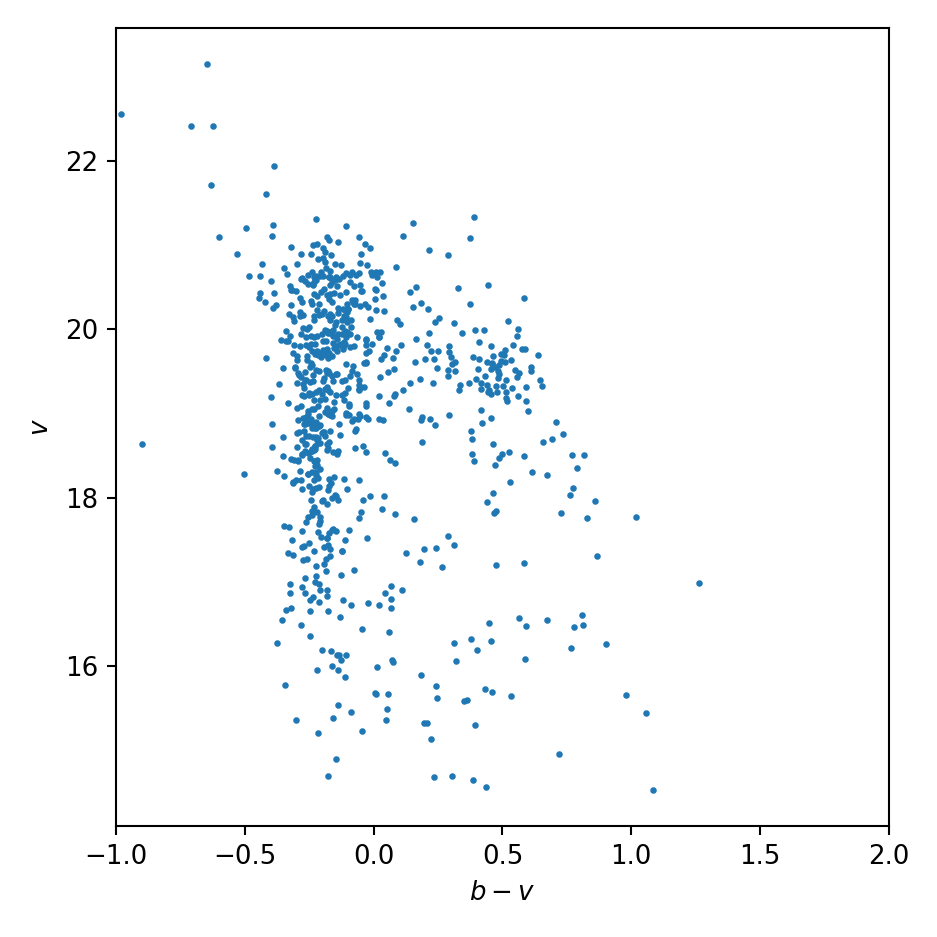

In [60]:
gi_color = ap_g['mag']-ap_i['mag']
imag = ap_i['mag']

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(gi_color, imag, '.', ms=3.0)
ax.set_xlim([-1.0, 2.0])
#ax.set_ylim([25.5, 19.5])
ax.set_xlabel(r"$b-v$")
ax.set_ylabel(r"$v$")
# HolmIX = ((ap_g['x'] >= 1350) & (ap_g['x'] <= 1850) & (ap_g['y'] >= 750) & (ap_g['y'] <= 1250))
# ax.plot(gi_color[HolmIX], imag[HolmIX], '.', ms=4.0, color='red')
plt.tight_layout()